In [1]:
print("Hello")

Hello


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5789 - loss: 0.9017 - val_accuracy: 0.7001 - val_loss: 0.5672
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 947ms/step - accuracy: 0.7009 - loss: 0.5586 - val_accuracy: 0.7743 - val_loss: 0.4810
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 968ms/step - accuracy: 0.7825 - loss: 0.4658 - val_accuracy: 0.7974 - val_loss: 0.4357
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 990ms/step - accuracy: 0.8058 - loss: 0.4211 - val_accuracy: 0.8120 - val_loss: 0.4148
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 98s 976ms/step - accuracy: 0.8097 - loss: 0.4122 - val_accuracy: 0.8167 - val_loss: 0.4003
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 316ms/step - accuracy: 0.8152 - loss: 0.4021
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


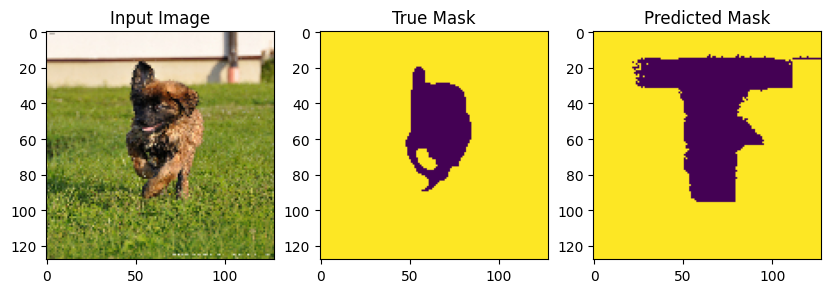

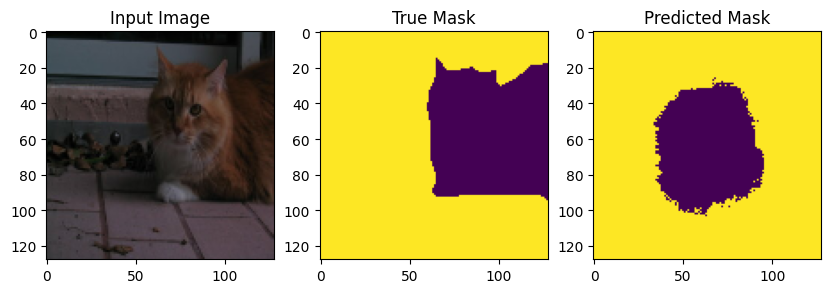

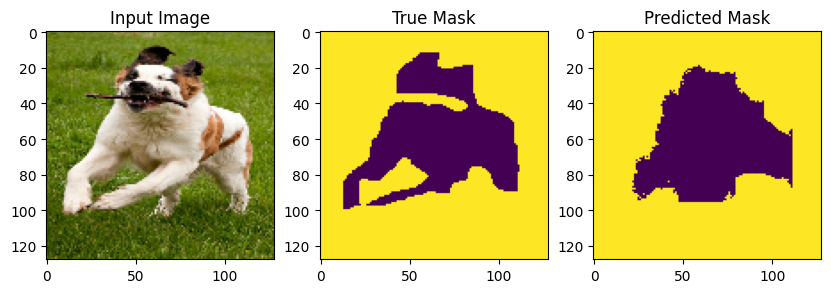

In [10]:
# ✅ Step 1: Install required packages (Colab cell)
!pip install -q tensorflow tensorflow-datasets einops

# ✅ Step 2: Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from einops import rearrange

# ✅ Step 3: Load the Oxford Pets dataset (with segmentation masks)
def normalize_img(input_image, input_mask, num_classes=3):
    input_image = tf.image.resize(input_image, (128, 128)) / 255.0
    input_mask = tf.image.resize(input_mask, (128, 128))
    input_mask = tf.squeeze(input_mask, axis=-1)
    input_mask = tf.cast(input_mask, tf.int32)

    # Ensure that mask values are within [0, num_classes - 1]
    input_mask = tf.clip_by_value(input_mask, 0, num_classes - 1)

    return input_image, input_mask

def load_dataset(batch_size=32, num_classes=3):
    dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
    train = dataset['train'].map(lambda x: normalize_img(x['image'], x['segmentation_mask'], num_classes))
    test = dataset['test'].map(lambda x: normalize_img(x['image'], x['segmentation_mask'], num_classes))

    train = train.cache().shuffle(1000).batch(batch_size).repeat()
    test = test.batch(batch_size)
    return train, test, info

# Number of segmentation classes (adjust according to dataset)
num_classes = 3  # Background, pet, and outline
train_dataset, test_dataset, dataset_info = load_dataset(num_classes=num_classes)

# ✅ Step 4: Define Vision Transformer Encoder
def vit_encoder(num_patches=64, projection_dim=64, num_heads=4, transformer_layers=4):
    inputs = layers.Input(shape=(128, 128, 3))

    # Create patches
    x = layers.Conv2D(projection_dim, kernel_size=16, strides=16, padding='same')(inputs)  # (8, 8, proj_dim)
    x = layers.Reshape((num_patches, projection_dim))(x)  # (64, proj_dim)

    # Positional encoding
    pos_encoding = tf.Variable(tf.random.normal([1, num_patches, projection_dim]), trainable=True)
    x = layers.Add()([x, pos_encoding])

    # Transformer blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization()(x)
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([x, attn_output])
        x3 = layers.LayerNormalization()(x2)
        ffn_output = layers.Dense(projection_dim * 2, activation='gelu')(x3)
        ffn_output = layers.Dense(projection_dim)(ffn_output)
        x = layers.Add()([x2, ffn_output])

    # Reshape back to 2D feature map
    x = layers.Reshape((8, 8, projection_dim))(x)
    return tf.keras.Model(inputs, x, name="ViT_Encoder")


# ✅ Step 5: Define Decoder
def decoder_head(encoded, num_classes):
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation='relu')(encoded)  # 8 → 16
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation='relu')(x)        # 16 → 32
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation='relu')(x)        # 32 → 64
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation='relu')(x)        # 64 → 128
    x = layers.Conv2D(num_classes, kernel_size=1)(x)                                          # Final (128×128×num_classes)
    return x

# ✅ Step 6: Full Model (Encoder + Decoder)
def build_vit_segmentation_model(num_classes):
    vit = vit_encoder()
    inputs = vit.input
    x = vit.output
    outputs = decoder_head(x, num_classes)
    return tf.keras.Model(inputs, outputs)

model = build_vit_segmentation_model(num_classes)

# ✅ Step 7: Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ✅ Step 8: Train model
EPOCHS = 5
STEPS_PER_EPOCH = 100

model.fit(train_dataset,
          validation_data=test_dataset,
          steps_per_epoch=STEPS_PER_EPOCH,
          epochs=EPOCHS)

# ✅ Step 9: Evaluate
model.evaluate(test_dataset)

# ✅ Step 10: Visualize predictions
import matplotlib.pyplot as plt

def display_sample_predictions(dataset, model, num=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1)
        for i in range(num):
            plt.figure(figsize=(10, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i])
            plt.title("True Mask")
            plt.subplot(1, 3, 3)
            plt.imshow(preds[i])
            plt.title("Predicted Mask")
            plt.show()

display_sample_predictions(test_dataset, model)



In [11]:

test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 377ms/step - accuracy: 0.8152 - loss: 0.4021
Test Accuracy: 81.67%


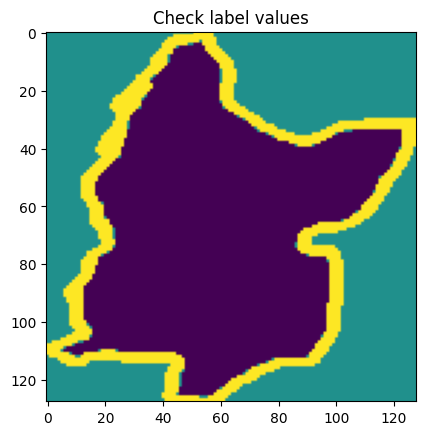

In [8]:
import matplotlib.pyplot as plt

for image, mask in train_dataset.take(1):
    plt.imshow(tf.squeeze(mask[0]))
    plt.title("Check label values")
    plt.show()
